In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv(
    "../coal-price-data/demand-forecasting-kernels-only/train.csv", index_col=0
)
data = data.reset_index()
data.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [3]:
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns")

The dataset has 913000 rows and 4 columns


In [4]:
data.describe()

store           item          sales
count  913000.000000  913000.000000  913000.000000
mean        5.500000      25.500000      52.250287
std         2.872283      14.430878      28.801144
min         1.000000       1.000000       0.000000
25%         3.000000      13.000000      30.000000
50%         5.500000      25.500000      47.000000
75%         8.000000      38.000000      70.000000
max        10.000000      50.000000     231.000000

In [5]:
data = data.loc[data["store"] <= 2]
print(f"The dataset now has {data.shape[0]} rows and {data.shape[1]} columns")

The dataset now has 182600 rows and 4 columns


In [6]:
data[["store", "item"]] = data[["store", "item"]].astype(str)

In [7]:
count_duplicate_rows = len(data) - len(data.drop_duplicates())
print(f"There are {count_duplicate_rows} duplicate rows")

There are 0 duplicate rows


In [8]:
data["store_item"] = data["store"] + "_" + data["item"]

In [9]:
data["date"] = pd.to_datetime(data["date"])

In [10]:
item_sales_per_date = data.groupby(["date", "store_item"])["sales"].aggregate(
    "sum"
)
item_sales_per_date = item_sales_per_date.reset_index()
item_sales_per_date.columns = ["date", "store_item", "sales"]
item_sales_per_date = item_sales_per_date.sort_values("date", ascending=True)
item_sales_per_date.head()

date store_item  sales
0  2013-01-01        1_1     13
72 2013-01-01        2_3     19
71 2013-01-01       2_29     50
70 2013-01-01       2_28     45
69 2013-01-01       2_27     17

In [11]:
item_sales_per_date.tail()

date store_item  sales
182527 2017-12-31       1_34     32
182526 2017-12-31       1_33     61
182524 2017-12-31       1_31     48
182535 2017-12-31       1_41     25
182599 2017-12-31        2_9     75

<Axes: xlabel='date'>

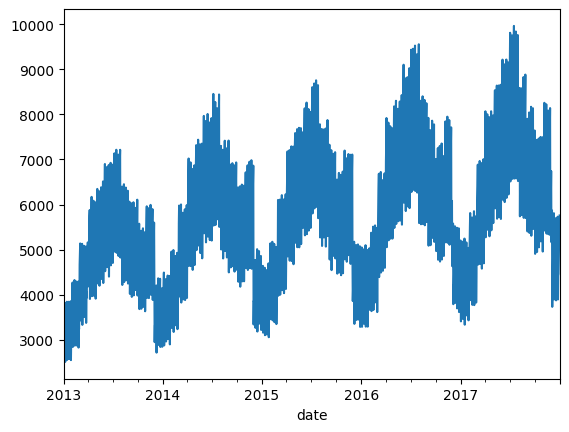

In [12]:
total_sales_per_date = item_sales_per_date.groupby(["date"])["sales"].aggregate(
    "sum"
)
total_sales_per_date.plot()

In [13]:
import itertools

multiindex = list(
    zip(item_sales_per_date["date"], item_sales_per_date["store_item"])
)
multiindex = pd.MultiIndex.from_tuples(multiindex, names=("index_1", "index_2"))

dataset = item_sales_per_date.copy()
dataset.index = multiindex


idx_dates = list(
    pd.date_range(
        min(item_sales_per_date["date"]), max(item_sales_per_date["date"])
    )
)
idx_ids = list(dataset["store_item"].unique())
idx = list(itertools.product(idx_dates, idx_ids))
dataset = dataset.reindex(idx)
dataset = dataset.reset_index()
dataset.head()

index_1 index_2       date store_item  sales
0 2013-01-01     1_1 2013-01-01        1_1     13
1 2013-01-01     2_3 2013-01-01        2_3     19
2 2013-01-01    2_29 2013-01-01       2_29     50
3 2013-01-01    2_28 2013-01-01       2_28     45
4 2013-01-01    2_27 2013-01-01       2_27     17

In [14]:
dataset["date"] = dataset["date"].fillna(dataset["index_1"])
dataset["store_item"] = dataset["store_item"].fillna(dataset["index_2"])
dataset["sales"] = dataset["sales"].fillna(0)
dataset = dataset.drop(columns=["index_1", "index_2"])
dataset = dataset.set_index("date")
dataset.index.name = "date"
dataset.head()

store_item  sales
date                        
2013-01-01        1_1     13
2013-01-01        2_3     19
2013-01-01       2_29     50
2013-01-01       2_28     45
2013-01-01       2_27     17

In [15]:
# Rename columns to match the Nixtlaverse's expectations
# The 'store_item' becomes 'unique_id' representing the unique identifier of the time series
# The 'date' becomes 'ds' representing the time stamp of the data points
# The 'sales' becomes 'y' representing the target variable we want to forecast
# Y_df = dataset.query('unique_id.str.startswith("6_46")').copy()
Y_df = dataset.copy()
Y_df = Y_df.reset_index()
Y_df = Y_df.rename(
    columns={"store_item": "unique_id", "date": "ds", "sales": "y"}
)
Y_df["y"] = Y_df["y"].astype(int)
# Convert the 'ds' column to datetime format to ensure proper handling of date-related operations in subsequent steps
Y_df["ds"] = pd.to_datetime(Y_df["ds"])
Y_df.tail()

Y_df["unique_id"] = Y_df["unique_id"].astype(str)
Y_df

ds unique_id   y
0      2013-01-01       1_1  13
1      2013-01-01       2_3  19
2      2013-01-01      2_29  50
3      2013-01-01      2_28  45
4      2013-01-01      2_27  17
...           ...       ...  ..
182595 2017-12-31      1_36  71
182596 2017-12-31      1_35  55
182597 2017-12-31      1_34  32
182598 2017-12-31      1_33  61
182599 2017-12-31      1_42  27

[182600 rows x 3 columns]

/tmp/ipykernel_5621/990006896.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


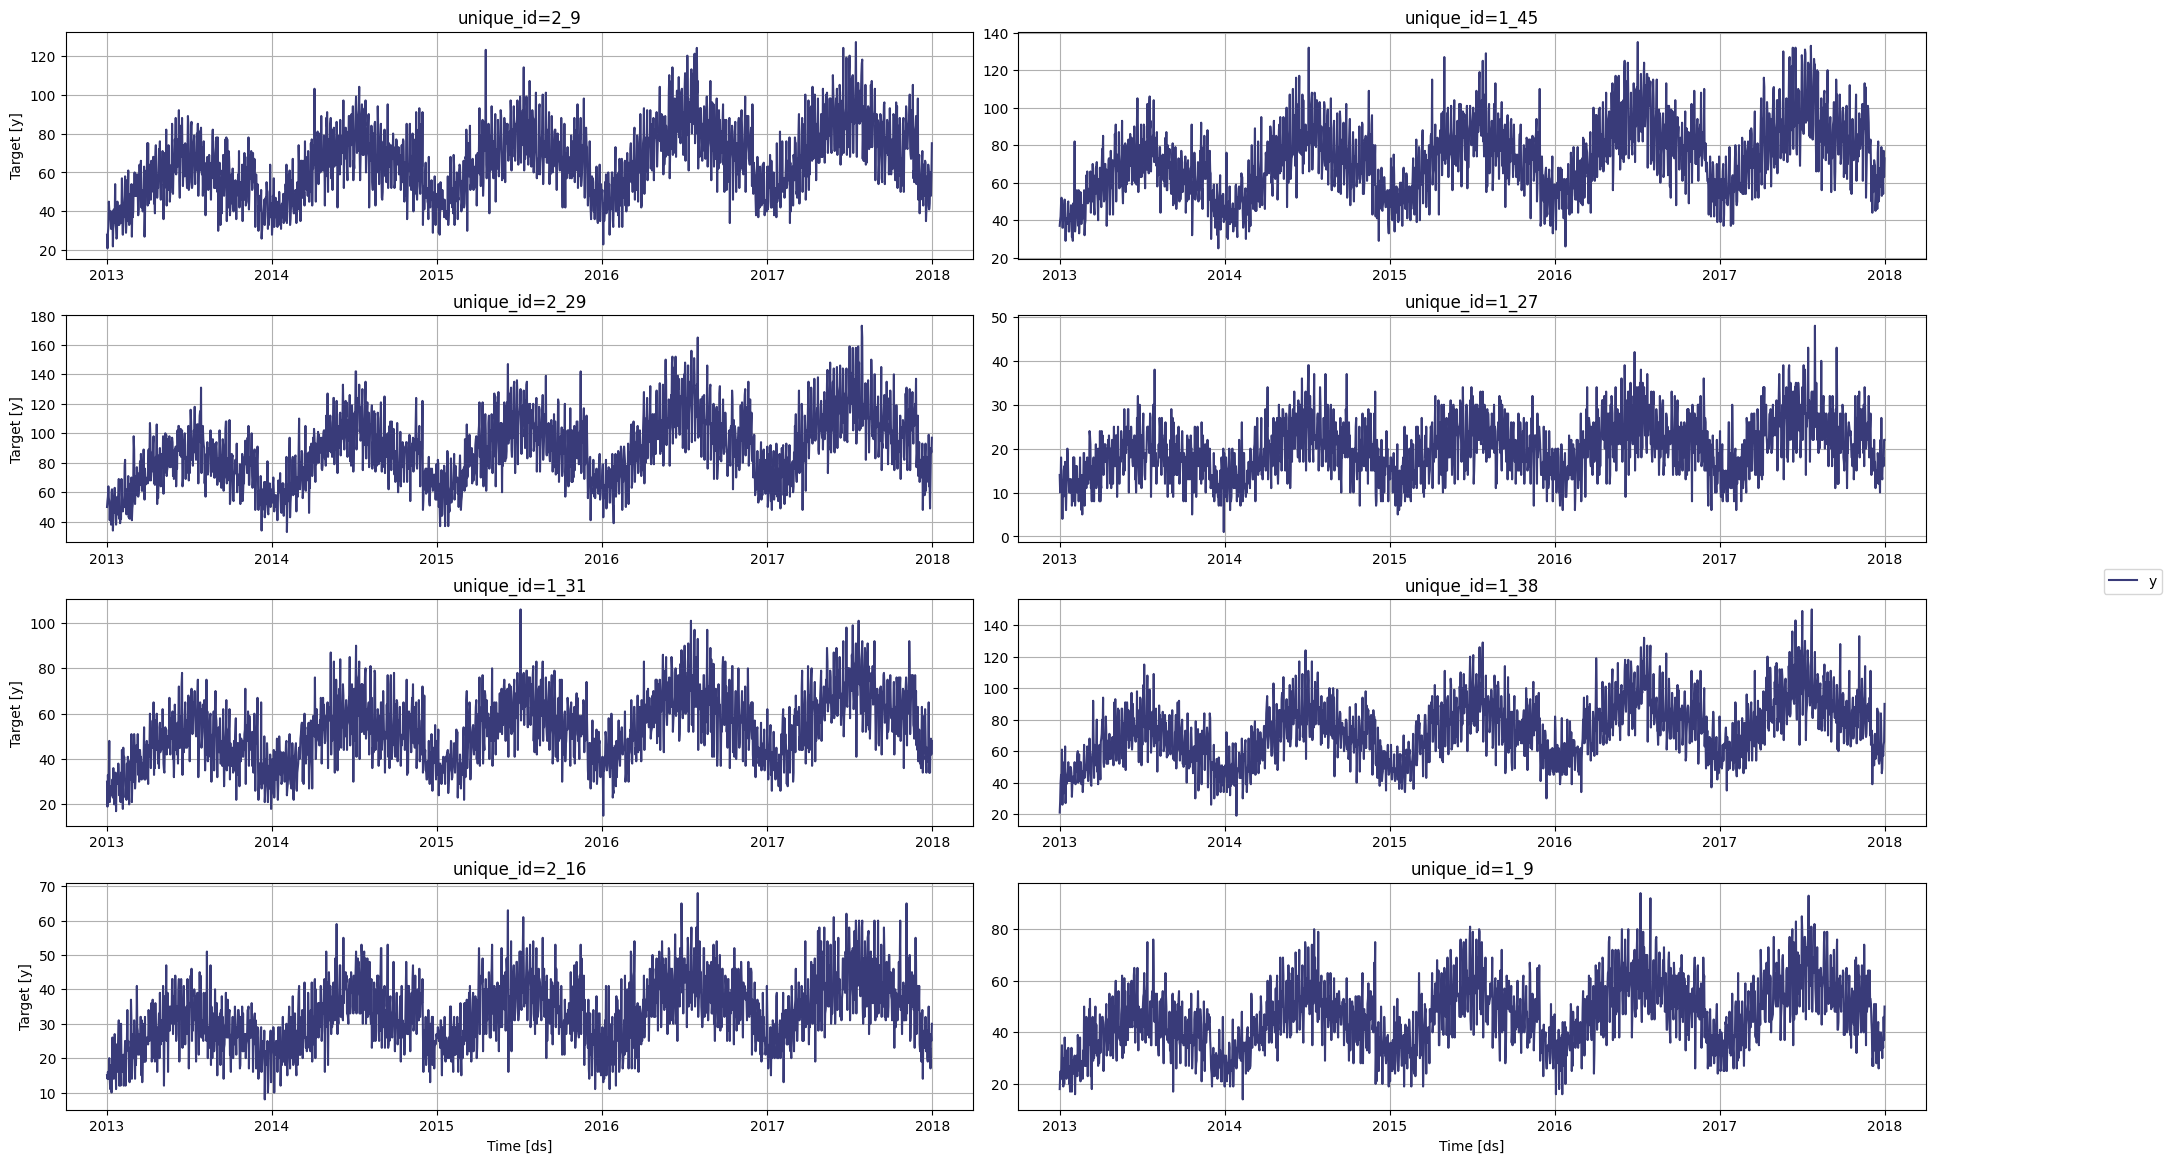

In [16]:
from tqdm.autonotebook import tqdm
from statsforecast import StatsForecast

# Plot random series for EDA
StatsForecast.plot(Y_df)

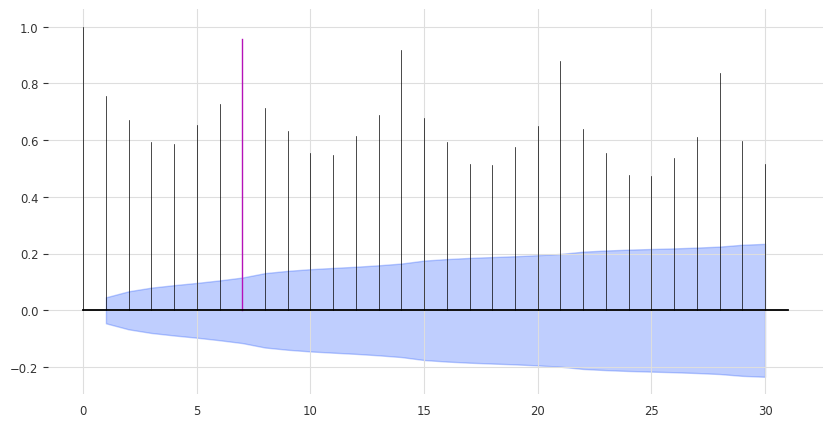

In [17]:
import darts
from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality

seasonality_check_data = total_sales_per_date.reset_index()
seasonality_check_data = seasonality_check_data.set_index("date")
seasonality_check_data_series = TimeSeries.from_times_and_values(
    seasonality_check_data.index, seasonality_check_data["sales"].values
)

plot_acf(seasonality_check_data_series, m=7, alpha=0.05, max_lag=30)

In [20]:
seasonality_check_data_series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)>
array([[[3058.]],

       [[3072.]],

       [[3192.]],

       ...,

       [[5141.]],

       [[5455.]],

       [[5758.]]])
Coordinates:
  * date       (date) datetime64[ns] 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) <U1 '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

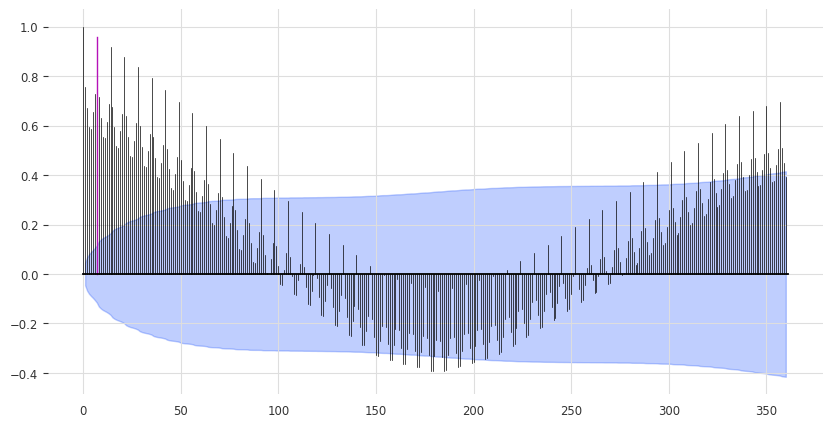

In [18]:
plot_acf(seasonality_check_data_series, m=7, alpha=0.05, max_lag=12 * 30)

In [22]:
from time import time

# Import necessary models from the statsforecast library
from statsforecast.models import (
    # SeasonalNaive: A model that uses the previous season's data as the forecast
    SeasonalNaive,
    # Naive: A simple model that uses the last observed value as the forecast
    Naive,
    # HistoricAverage: This model uses the average of all historical data as the forecast
    HistoricAverage,
    # CrostonOptimized: A model specifically designed for intermittent demand forecasting
    CrostonOptimized,
    # ADIDA: Adaptive combination of Intermittent Demand Approaches, a model designed for intermittent demand
    ADIDA,
    # IMAPA: Intermittent Multiplicative AutoRegressive Average, a model for intermittent series that incorporates autocorrelation
    IMAPA,
    # AutoETS: Automated Exponential Smoothing model that automatically selects the best Exponential Smoothing model based on AIC
    AutoETS,
)

# horizon is the number of days in the future for which we will make a forecast
horizon = 30
# the seasonality window is 7 because we have weekly seasonality
season_length = 7
# the number of days that the model will use to make a forecast
window_size = 6 * 30
models = [
    SeasonalNaive(season_length=season_length),
    Naive(),
    HistoricAverage(),
    CrostonOptimized(),
    ADIDA(),
    IMAPA(),
    AutoETS(season_length=season_length),
]

# Instantiate the StatsForecast class
sf = StatsForecast(
    models=models,  # A list of models to be used for forecasting
    freq="D",  # The frequency of the time series data (in this case, 'D' stands for daily frequency)
    n_jobs=-1,  # The number of CPU cores to use for parallel execution (-1 means use all available cores)
)

# Get the current time before forecasting starts, this will be used to measure the execution time
init = time()

# Call the forecast method of the StatsForecast instance to predict the next horizon days
# Level is set to [90], which means that it will compute the 90% prediction interval
fcst_df = sf.forecast(df=Y_df, h=horizon, level=[90], prediction_intervals=None)

# Get the current time after the forecasting ends
end = time()

# Calculate and print the total time taken for the forecasting in minutes
print(f"Forecast Minutes: {(end - init) / 60}")

Exception: You must pass `prediction_intervals` to compute them.